# Ultrasound Image Segmentation on U-Net with Luminous Database

In [ ]:
%cd /content
!git clone https://github.com/hijihyo/pytorch-unet.git
%cd /content/pytorch-unet
!chmod 744 scripts/setup.sh
!chmod 744 scripts/download_luminous.sh
!./scripts/setup.sh
!./scripts/download_luminous.sh
%cd /content/pytorch-unet

In [5]:
!cp /content/drive/MyDrive/model.tar.gz .
!tar -zxvf model.tar.gz
!rm model.tar.gz

.model/
.model/model_62_-0.1887.pt
.model/model_56_-0.1774.pt
.model/model_66_-0.1842.pt


In [7]:
!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 259 kB 4.2 MB/s 


In [13]:
import random
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

from ignite.handlers import Checkpoint, ModelCheckpoint

from data import Luminous
from model import UNet
from utils import collate_batch, SegmentationLoss

transform = T.Compose([
  T.ToTensor(),
  T.Pad((6, 5)),  # (614, 820) -> (624, 832)
])
dataset = Luminous(transform=transform, target_transform=transform)

device = "cuda" if torch.cuda.is_available() else "cpu"
IN_CHANNELS = 1
NUM_CLASSES = 2
DROPOUT = 0.5

model = UNet(IN_CHANNELS, NUM_CLASSES, DROPOUT).to(device)
to_save = {"model": model}
model_checkpoint = torch.load(".model/model_56_-0.1774.pt", map_location=device)
Checkpoint.load_objects(to_load=to_save, checkpoint=model_checkpoint) 

In [18]:
from torch.utils.data import DataLoader
from ignite.contrib.handlers import ProgressBar
from ignite.engine import create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, IoU
from ignite.metrics.confusion_matrix import ConfusionMatrix

dataloader = DataLoader(dataset, batch_size=2, collate_fn=collate_batch)
val_metrics = {
  "accuracy": Accuracy(),
  "loss": Loss(SegmentationLoss(num_classes=NUM_CLASSES)),
  "IoU": IoU(ConfusionMatrix(NUM_CLASSES)),
}
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
ProgressBar().attach(evaluator)

evaluator.run(dataloader)
metrics = evaluator.state.metrics
print(f"[DATA] avg. acc: {metrics['accuracy']:.5f} avg. loss: {metrics['loss']:.5f} avg. IoU: {metrics['IoU'].mean():.5f}")

[1/193]   1%|           [00:00<?]

[DATA] avg. acc: 0.97404 avg. loss: 0.16208 avg. IoU: 0.82737


In [15]:
def predict(model, data, device):
    model.eval()
    loss = None
    with torch.no_grad():
        imgs, masks = data
        imgs, masks = imgs.to(device), masks.to(device, dtype=torch.long)
        preds = model(imgs)
    return preds

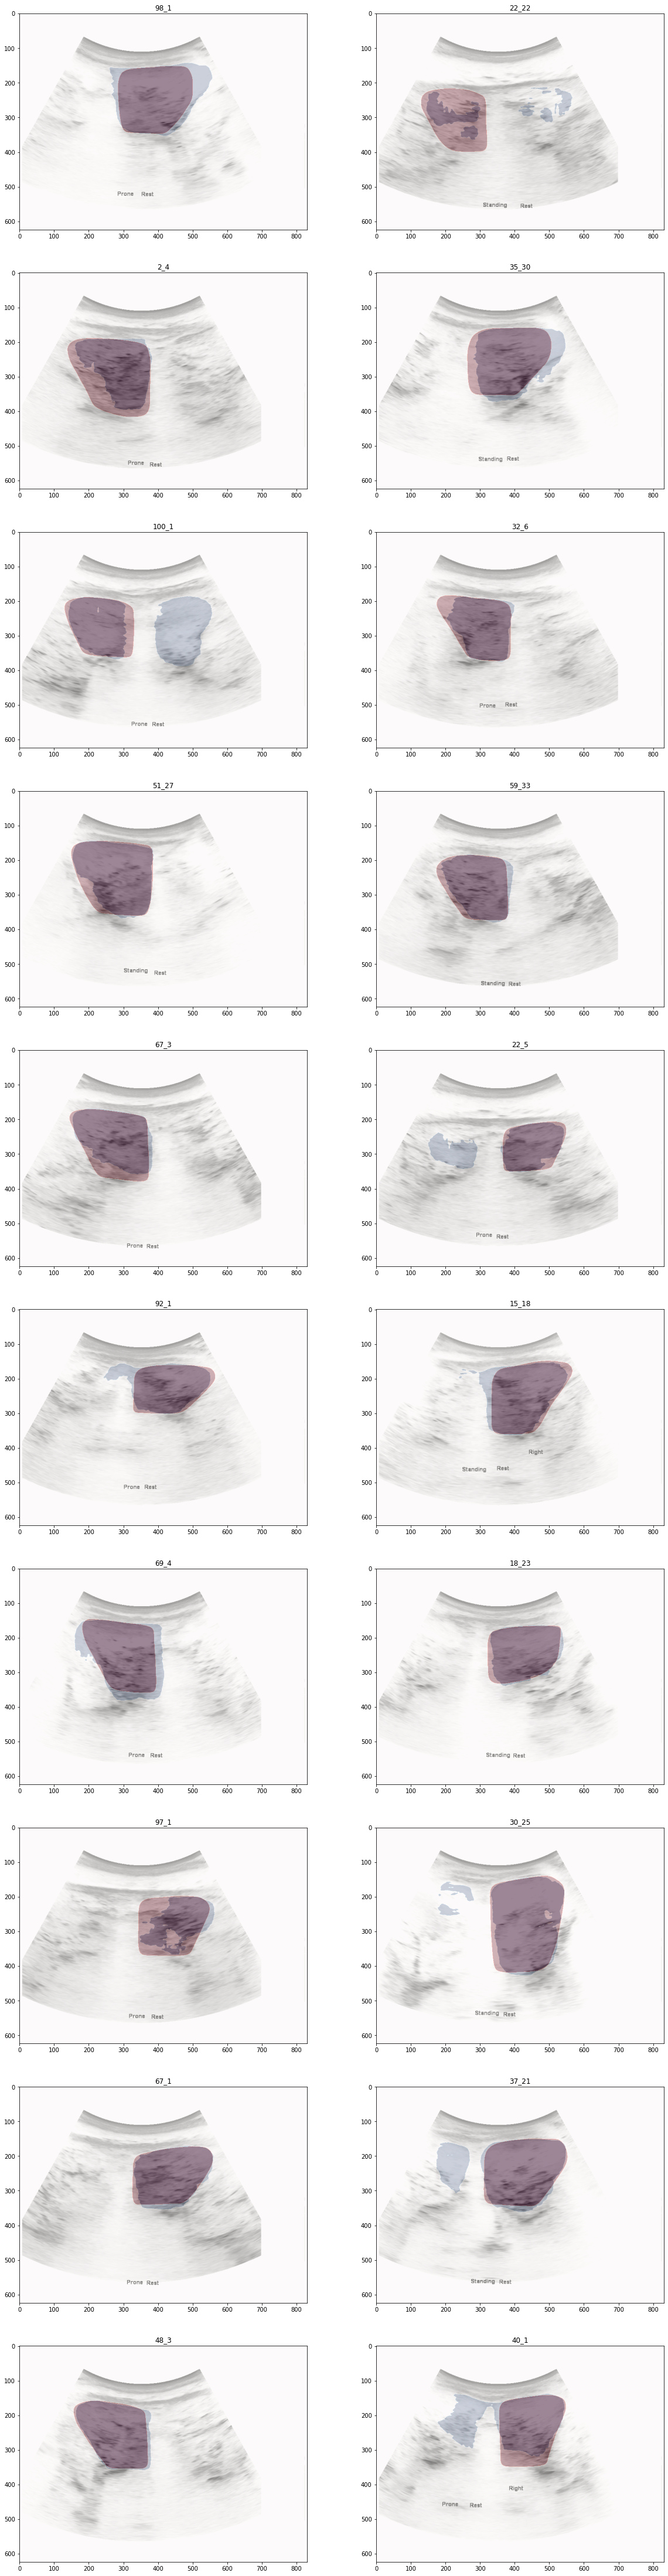

In [17]:
nrows = 10
ncols = 2
plt.figure(figsize=(ncols * 10, nrows * 8))
for i in range(nrows):
  for j in range(ncols):
    index = random.randint(0, len(dataset))
    name = dataset.imgs[index][:dataset.imgs[index].rfind("_")]

    img, mask = dataset[index]
    preds = predict(model, collate_batch([dataset[index]]), device)
    pred = preds.squeeze(0)

    plt.subplot(nrows, ncols, i * ncols + j + 1)
    plt.title(name)
    plt.imshow(img.permute(1, 2, 0).squeeze(-1), cmap="Greys")
    plt.imshow(pred.argmax(dim=0).cpu(), cmap="Blues", alpha=0.3)
    plt.imshow(mask.permute(1, 2, 0).squeeze(-1), cmap="Reds", alpha=0.3)
plt.show()

In [19]:
!cp /content/drive/MyDrive/encoder.tar.gz .
!tar -zxvf encoder.tar.gz
!rm encoder.tar.gz

.encoder/
.encoder/encoder_56_-0.1774.pt
.encoder/encoder_62_-0.1887.pt
.encoder/encoder_66_-0.1842.pt


In [21]:
from model import UNetEncoder

device = "cuda" if torch.cuda.is_available() else "cpu"
IN_CHANNELS = 1
NUM_CLASSES = 2
DROPOUT = 0.5
kernel_size = 3
stride = 1
padding = (kernel_size - stride) // 2
channels = [64, 128, 256, 512, 1024]

encoder = UNetEncoder(IN_CHANNELS, channels, kernel_size, stride, padding, DROPOUT).to(device)
to_save = {"encoder": encoder}
encoder_checkpoint = torch.load(".encoder/encoder_56_-0.1774.pt", map_location=device)
Checkpoint.load_objects(to_load=to_save, checkpoint=encoder_checkpoint) 

In [22]:
index = random.randint(0, len(dataset))
outputs, _ = predict(encoder, collate_batch([dataset[index]]), device)
output = outputs.squeeze(0)
print(output.size())

torch.Size([1024, 39, 52])


In [25]:
from torch import pca_lowrank
index = random.randint(0, len(dataset))
outputs, _ = predict(encoder, collate_batch([dataset[index]]), device)
output = outputs.squeeze(0).permute(1, 2, 0)
_, _, V = pca_lowrank(output)
print(torch.matmul(output, V[:, :, :1]).size())

torch.Size([39, 52, 1])


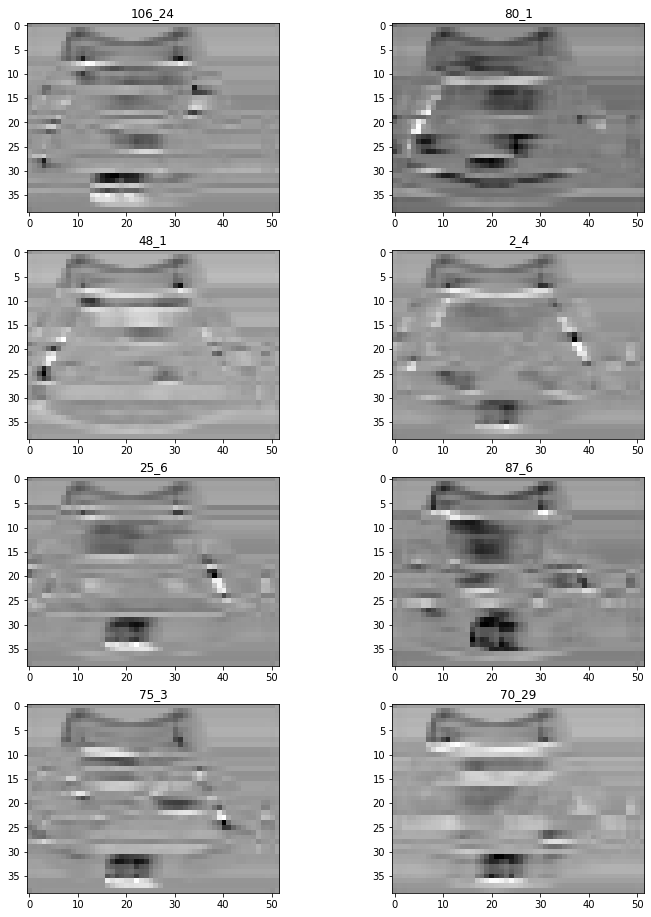

In [28]:
nrows = 4
ncols = 2
plt.figure(figsize=(ncols * 6, nrows * 4))
for i in range(nrows):
  for j in range(ncols):
    index = random.randint(0, len(dataset))
    name = dataset.imgs[index][:dataset.imgs[index].rfind("_")]

    outputs, _ = predict(encoder, collate_batch([dataset[index]]), device)
    output = outputs.squeeze(0).permute(1, 2, 0)
    _, _, V = pca_lowrank(output)
    output = torch.matmul(output, V[:, :, :1]).squeeze(-1)

    plt.subplot(nrows, ncols, i * ncols + j + 1)
    plt.title(name)
    plt.imshow(output.cpu(), cmap="Greys")
plt.show()